# Adapted Correlation Tensor Methodology [(EDLM, Agrawal et al., 2022)](https://www.techscience.com/cmc/v70n1/44330/html)


In [34]:
import warnings
warnings.filterwarnings('ignore')

In [35]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from scipy.stats import pearsonr

In [36]:
class CorrelationTensorLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(CorrelationTensorLayer, self).__init__(**kwargs)
        self.feature_count = None

    def build(self, input_shape):
        self.feature_count = input_shape[-1]
        self.correlation_weights = self.add_weight(
            shape=(self.feature_count, self.feature_count),
            initializer='glorot_uniform',
            trainable=True,
            name='correlation_weights'
        )
        super().build(input_shape)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        time_steps = tf.shape(inputs)[1]
        features = self.feature_count
        reshaped_inputs = tf.reshape(inputs, [batch_size * time_steps, features])
        mean_features = tf.reduce_mean(reshaped_inputs, axis=0, keepdims=True)
        centered_features = reshaped_inputs - mean_features
        covariance_matrix = tf.matmul(tf.transpose(centered_features), centered_features)
        covariance_matrix /= tf.cast(tf.shape(centered_features)[0], tf.float32)
        std_devs = tf.sqrt(tf.reduce_mean(tf.square(centered_features), axis=0))
        outer_product_std_devs = tf.matmul(
            tf.expand_dims(std_devs, 1),
            tf.expand_dims(std_devs, 0)
        )
        corr_matrix = covariance_matrix / (outer_product_std_devs + 1e-8)
        weighted_corr = corr_matrix * self.correlation_weights
        corr_tensors = tf.reshape(weighted_corr, [1, features, features])
        corr_tensors = tf.tile(corr_tensors, [batch_size, 1, 1])
        enhanced_features = tf.reduce_sum(corr_tensors, axis=-1)
        enhanced_features = tf.reshape(enhanced_features, [batch_size, time_steps, features])
        return tf.concat([inputs, enhanced_features], axis=-1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], input_shape[2] * 2)

In [37]:
def evaluate_model(y_true, y_pred, model_name):
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n--- {model_name} Evaluation ---")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2}

In [38]:
def build_edlm_model(input_shape, learning_rate=0.001):
    input_layer = Input(shape=input_shape)
    corr_tensor = CorrelationTensorLayer()(input_layer)
    lstm_stage1 = LSTM(64, return_sequences=True)(corr_tensor)
    lstm_stage2 = LSTM(32, return_sequences=True)(lstm_stage1)
    dropout_stage2 = Dropout(0.2)(lstm_stage2)
    lstm_stage3 = LSTM(16, return_sequences=True)(dropout_stage2)
    lstm_stage4 = LSTM(8, return_sequences=False)(lstm_stage3)
    dense0 = Dense(16, activation='relu')(lstm_stage4)
    dense1 = Dense(16, activation='relu')(dense0)
    dense2 = Dense(8, activation='relu')(dense1)
    output = Dense(1, activation='linear')(dense2)
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model

In [39]:
def create_correlation_features(df, target_col='Out'):
    df = df.copy()
    if 'Date' in df.columns or df.index.dtype.kind == 'M':
        date_series = df.index if df.index.dtype.kind == 'M' else pd.to_datetime(df['Date'])
        df.interpolate(method='linear', inplace=True)
        df["Day"] = date_series.day
        df['Month'] = date_series.month
        df['Year'] = date_series.year
        if target_col in df.columns:
            df[f'{target_col}_MA3'] = df[target_col].rolling(window=3).mean().fillna(method='bfill')
            df[f'{target_col}_MA7'] = df[target_col].rolling(window=7).mean().fillna(method='bfill')
            df[f'{target_col}_Std7'] = df[target_col].rolling(window=7).std().fillna(method='bfill')
            df[f'{target_col}_Change'] = df[target_col].pct_change().fillna(0)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    for i, col1 in enumerate(numeric_cols):
        if col1 == target_col:
            continue
        df[f'{col1}_squared'] = df[col1] ** 2
        for col2 in numeric_cols[i+1:]:
            if col2 == target_col:
                continue
            df[f'{col1}_{col2}_interact'] = df[col1] * df[col2]
    correlations = {}
    for column in df.columns:
        if column != target_col and df[column].dtype.kind in 'bifc':
            if df[column].std() == 0:
                correlations[column] = 0
            else:
                correlation = pearsonr(df[column].fillna(0), df[target_col])[0]
                correlations[column] = correlation if not np.isnan(correlation) else 0
    for column in correlations:
        df[f'Corr_{column}'] = correlations[column]
    df = df.dropna()
    return df

In [40]:
def train_edlm_sales_model(df, target_col='Out', test_size=0.2, epochs=50, batch_size=16, verbose=1):
    df_copy = df.copy()
    df_processed = create_correlation_features(df_copy, target_col)
    feature_cols = df_processed.columns.drop(target_col)
    X = df_processed[feature_cols].values
    y = df_processed[target_col].values.reshape(-1, 1)
    if np.isnan(X).any() or np.isnan(y).any():
        raise ValueError("Input data contains NaN values after processing.")
    X = np.clip(X, -1e6, 1e6)
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=test_size, shuffle=False)
    X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
    model = build_edlm_model(input_shape=(1, X_train.shape[1]))
    callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
    history = model.fit(
        X_train_lstm, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose,
        validation_split=0.1, callbacks=callbacks
    )
    y_pred = model.predict(X_test_lstm)
    y_test_inv = scaler_y.inverse_transform(y_test)
    y_pred_inv = scaler_y.inverse_transform(y_pred)
    metrics = evaluate_model(y_test_inv, y_pred_inv, "EDLM Sales Opportunity Model")
    return {
        "model": model, "history": history, "metrics": metrics,
        "scalers": {"X": scaler_X, "y": scaler_y}, "feature_cols": feature_cols,
        "test_data": {"X_test": X_test, "y_test": y_test, "y_pred": y_pred}
    }

In [41]:
df = pd.read_csv("/content/Data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [42]:
result = train_edlm_sales_model(df=df, target_col='Out', epochs=200, batch_size=16, verbose=1)
model = result['model']
X_test_lstm = result['test_data']['X_test'].reshape((result['test_data']['X_test'].shape[0], 1, result['test_data']['X_test'].shape[1]))
y_pred = model.predict(X_test_lstm)

print("Model training and prediction completed successfully.")

Epoch 1/200
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0443 - mae: 0.1591 - val_loss: 0.0133 - val_mae: 0.1067
Epoch 2/200
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0071 - mae: 0.0616 - val_loss: 0.0110 - val_mae: 0.0909
Epoch 3/200
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0025 - mae: 0.0371 - val_loss: 0.0035 - val_mae: 0.0457
Epoch 4/200
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0012 - mae: 0.0253 - val_loss: 0.0011 - val_mae: 0.0236
Epoch 5/200
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.8492e-04 - mae: 0.0227 - val_loss: 7.0111e-04 - val_mae: 0.0198
Epoch 6/200
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 8.3797e-04 - mae: 0.0213 - val_loss: 0.0030 - val_mae: 0.0488
Epoch 7/200
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 8.9940e-04 - mae: 0.0226 - val_loss: 0.0015 - val_mae: 0.0319
Epoch 8/200
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.4695e-04 - mae: 0.0205 - val_loss: 7.5907e-04 - val_mae: 0.0224
Epoch 9/200
106/

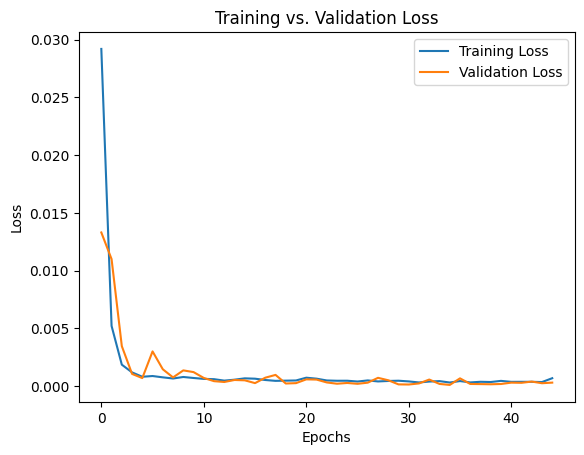

In [43]:
import matplotlib.pyplot as plt

plt.plot(result['history'].history['loss'], label='Training Loss')
plt.plot(result['history'].history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()


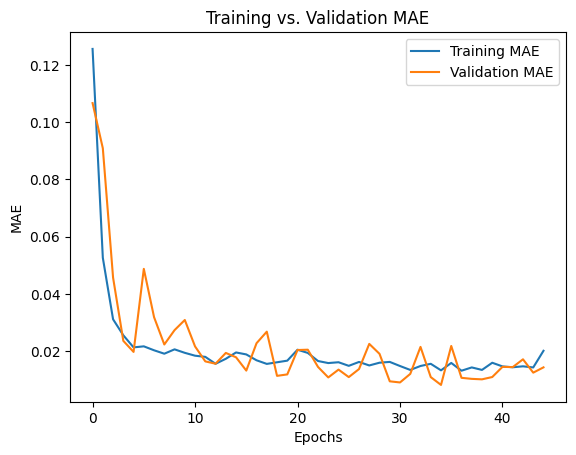

In [44]:
import matplotlib.pyplot as plt

plt.plot(result['history'].history['mae'], label='Training MAE')
plt.plot(result['history'].history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training vs. Validation MAE')
plt.legend()
plt.show()

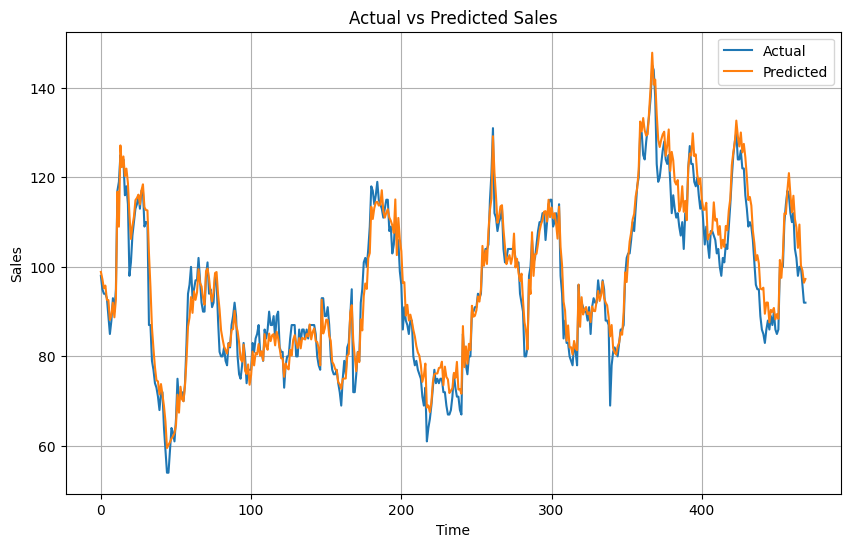

In [45]:
import matplotlib.pyplot as plt

y_test_inv = result['scalers']['y'].inverse_transform(result['test_data']['y_test'])
y_pred_inv = result['scalers']['y'].inverse_transform(y_pred)

plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.grid(True)
plt.show()
